In [1]:
import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d


In [2]:
# Function to find common wavelength range and flux for two spectra
def find_common_range(wavelength1, flux1, wavelength2, flux2):
    common_range = np.intersect1d(wavelength1, wavelength2)
    indices1 = np.searchsorted(wavelength1, common_range, side='left')
    indices2 = np.searchsorted(wavelength2, common_range, side='left')
    indices1 = np.clip(indices1, 0, len(flux1) - 1)
    indices2 = np.clip(indices2, 0, len(flux2) - 1)
    common_flux1 = flux1[indices1]
    common_flux2 = flux2[indices2]
    return common_range, common_flux1, common_flux2

In [3]:
# Function to normalize the spectrum within a specified wavelength range
def normalize_spectrum(wavelengths, spectrum, wavelength_range):
    # Ensure only wavelengths within the specified range are considered
    selected_indices = np.where((wavelengths >= wavelength_range[0]) & (wavelengths <= wavelength_range[1]))[0]
    selected_wavelengths = wavelengths[selected_indices]
    selected_spectrum = spectrum[selected_indices]
    
    # Normalize the spectrum between 0 and 1
    normalized_spectrum = (selected_spectrum - np.min(selected_spectrum)) / (np.max(selected_spectrum) - np.min(selected_spectrum))
    
    return selected_wavelengths, normalized_spectrum

In [4]:
# Load Transiting Spectrum
transit_file = "spec-58050-KP194045N483045V06_sp10-054.fits"
data_transit = fits.open(transit_file)

# Blue arm spectra
transit_wvb = data_transit[1].data["WAVELENGTH"]
transit_blue = data_transit[1].data["FLUX"]

In [5]:
# Load Non-Transit Spectrum
non_transit_file = "spec-57919-KP192314N471144V04_sp09-033.fits"
data_non_transit = fits.open(non_transit_file)

# Blue arm spectrum
non_transit_blue = data_non_transit[1].data["FLUX"]
non_transit_wvb = data_transit[1].data["WAVELENGTH"]


In [6]:

# Find common wavelength range for red and blue arms
common_range_blue, transit_blue_common, non_transit_blue_common = find_common_range(transit_wvb[0], transit_blue[0], non_transit_wvb[0], non_transit_blue[0])

# Calculate median flux for each arm
median_flux_blue = np.median(transit_blue_common)

# Normalize spectra between 0 and 1
normalized_blue = (transit_blue_common - np.min(transit_blue_common)) / (np.max(transit_blue_common) - np.min(transit_blue_common))
normalized_non_transit_blue = (non_transit_blue_common  - np.min(non_transit_blue_common)) / (np.max(non_transit_blue_common) - np.min(non_transit_blue_common))


'''
# Specify the wavelength range for normalization
wavelength_range = (4100, 9000)

# Normalize transit and non-transit spectra for the blue arm within the specified wavelength range
selected_wavelengths_blue_transit, normalized_transit_blue = normalize_spectrum(transit_wvb, transit_blue, wavelength_range)
selected_wavelengths_blue_non_transit, normalized_non_transit_blue = normalize_spectrum(non_transit_wvb, non_transit_blue, wavelength_range)


# Find common wavelength range for red and blue arms
common_range_blue, transit_blue_common, non_transit_blue_common = find_common_range(selected_wavelengths_blue_transit[0], normalized_transit_blue[0], selected_wavelengths_blue_non_transit[0], normalized_non_transit_blue[0])
'''


'\n# Specify the wavelength range for normalization\nwavelength_range = (4100, 9000)\n\n# Normalize transit and non-transit spectra for the blue arm within the specified wavelength range\nselected_wavelengths_blue_transit, normalized_transit_blue = normalize_spectrum(transit_wvb, transit_blue, wavelength_range)\nselected_wavelengths_blue_non_transit, normalized_non_transit_blue = normalize_spectrum(non_transit_wvb, non_transit_blue, wavelength_range)\n\n\n# Find common wavelength range for red and blue arms\ncommon_range_blue, transit_blue_common, non_transit_blue_common = find_common_range(selected_wavelengths_blue_transit[0], normalized_transit_blue[0], selected_wavelengths_blue_non_transit[0], normalized_non_transit_blue[0])\n'

Absorption Lines in Transit Spectrum (Blue Arm): [6564.4766]
Absorption Lines in Non-Transit Spectrum (Blue Arm): [6564.4766]


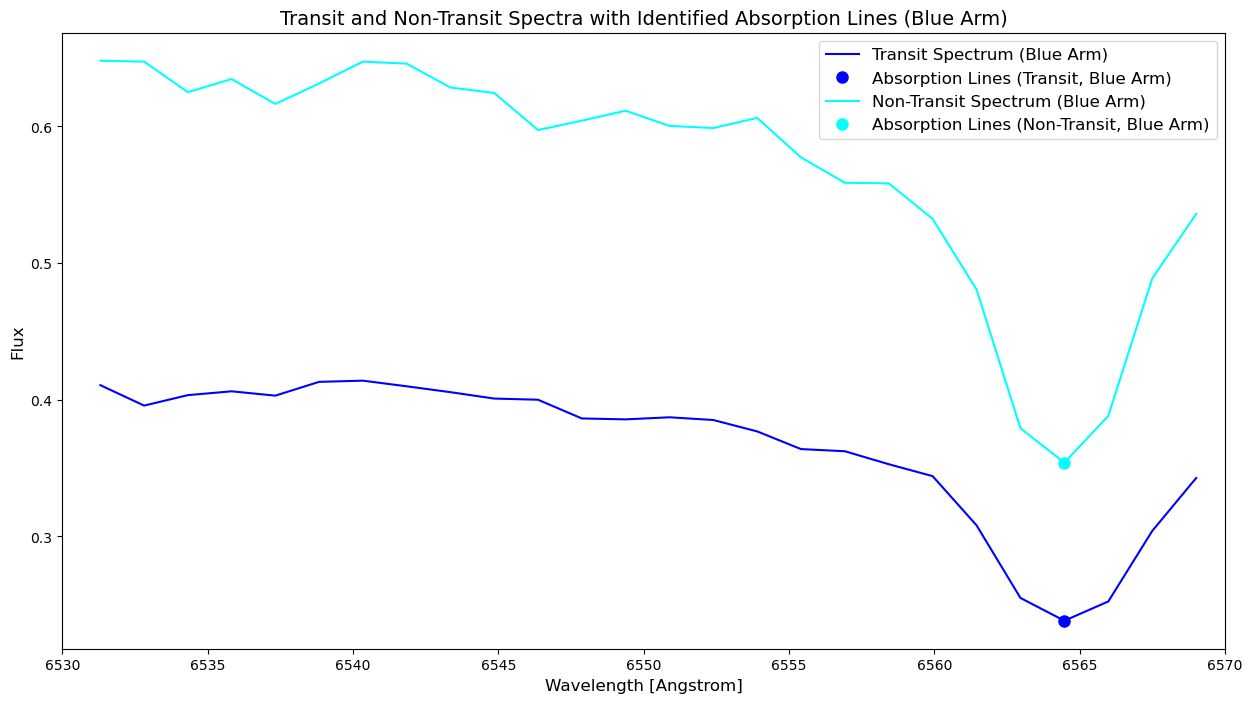

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

def find_and_plot_absorption_lines(transit_spectrum_blue, non_transit_spectrum_blue, common_range_blue, wavelength_range, sensitivity):
    # Select the data within the wavelength range
    mask_blue = (common_range_blue >= wavelength_range[0]) & (common_range_blue <= wavelength_range[1])

    # Check if there is any data in the wavelength range for the blue arm
    if not np.any(mask_blue):
        print("No data in the specified wavelength range for the blue arm.")
        return

    # Find local minima in the blue arm transit spectrum
    minima_transit_blue = argrelextrema(transit_spectrum_blue[mask_blue], np.less, order=10)[0]

    # Find local minima in the blue arm non-transit spectrum
    minima_non_transit_blue = argrelextrema(non_transit_spectrum_blue[mask_blue], np.less, order=10)[0]

    # Print the wavelength values corresponding to the identified absorption lines
    print("Absorption Lines in Transit Spectrum (Blue Arm):", common_range_blue[mask_blue][minima_transit_blue])
    print("Absorption Lines in Non-Transit Spectrum (Blue Arm):", common_range_blue[mask_blue][minima_non_transit_blue])

    # Create a new figure
    plt.figure(figsize=(15, 8))

    # Plot the spectra with identified absorption lines
    plt.plot(common_range_blue[mask_blue], transit_spectrum_blue[mask_blue], label='Transit Spectrum (Blue Arm)', color='blue')
    plt.plot(common_range_blue[mask_blue][minima_transit_blue], transit_spectrum_blue[mask_blue][minima_transit_blue], 'o', color='blue', markersize=8, label='Absorption Lines (Transit, Blue Arm)')

    plt.plot(common_range_blue[mask_blue], non_transit_spectrum_blue[mask_blue], label='Non-Transit Spectrum (Blue Arm)', color='cyan')
    plt.plot(common_range_blue[mask_blue][minima_non_transit_blue], non_transit_spectrum_blue[mask_blue][minima_non_transit_blue], 'o', color='cyan', markersize=8, label='Absorption Lines (Non-Transit, Blue Arm)')

    # Set x-axis limits
    plt.xlim(wavelength_range[0], wavelength_range[1])

    # Adjust the figure layout
    plt.xlabel('Wavelength [Angstrom]', fontsize=12)
    plt.ylabel('Flux', fontsize=12)
    plt.legend(fontsize=12)
    plt.title('Transit and Non-Transit Spectra with Identified Absorption Lines (Blue Arm)', fontsize=14)

    plt.show()

# Example usage (replace with your actual values)
# Assuming you have transit_spectrum_blue, non_transit_spectrum_blue, common_range_blue, and other variables defined
find_and_plot_absorption_lines(normalized_blue, normalized_non_transit_blue, common_range_blue, [6530, 6570], sensitivity=0.01)

In [8]:
corrected_wavelength_blue_transit=[]
corrected_wavelength_blue_non_transit=[]

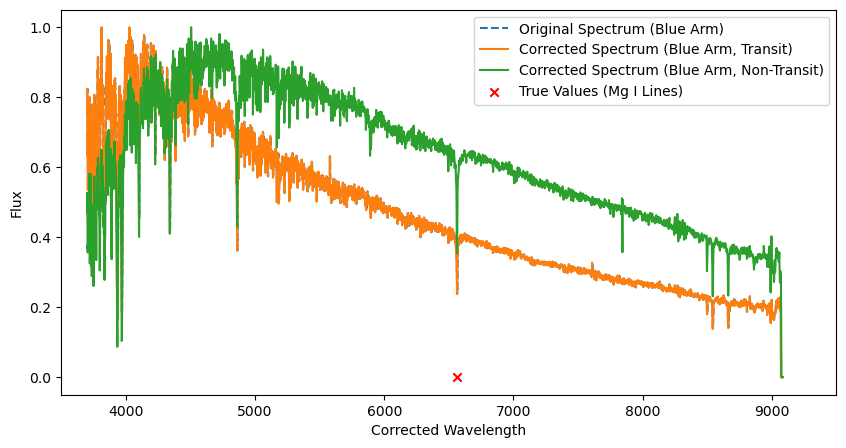

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def correct_wavelength_with_calibration(transit_spectrum, common_range, true_peak_wavelengths, observed_peak_wavelengths_transit, observed_peak_wavelengths_non_transit):
    # Calculate the correction factors based on the true and observed peaks for transit and non-transit
    correction_factor_transit = np.mean(true_peak_wavelengths - observed_peak_wavelengths_transit)
    correction_factor_non_transit = np.mean(true_peak_wavelengths - observed_peak_wavelengths_non_transit)

    # Correct the wavelength scale of the transit and non-transit spectra separately
    corrected_wavelength_transit = common_range + correction_factor_transit
    corrected_wavelength_non_transit = common_range + correction_factor_non_transit

    return corrected_wavelength_transit, corrected_wavelength_non_transit
''''
# Example true values for Mg I lines from a high-resolution reference spectrum
mg_i_lines_true_values = np.array([5172.684, 5183.604])

# Example observed values for Mg I lines in transit and non-transit spectra
observed_peaks_transit_blue = np.array([5173.4463, 5184.4175])  # Adjust with actual peak values
observed_peaks_non_transit_blue = np.array([5164.0454, 5174.878])  # Adjust with actual peak values

# Use the actual common range for the blue arm obtained from find_common_range
common_range_blue, _, _ = find_common_range(transit_wvb[0], transit_blue[0], transit_wvb[0], non_transit_blue[0])
'''
# Example true values for Mg I lines from a high-resolution reference spectrum
mg_i_lines_true_values = np.array([6562.8])

# Example observed values for Mg I lines in transit and non-transit spectra
observed_peaks_transit_blue = np.array([6564.4766])  # Adjust with actual peak values
observed_peaks_non_transit_blue = np.array([6564.4766])  # Adjust with actual peak values

# Use the actual common range for the blue arm obtained from find_common_range
#common_range_blue, _, _ = find_common_range(transit_wvb[0], transit_blue[0], transit_wvb[0], non_transit_blue[0])

# Correct the wavelength scale separately for transit and non-transit
corrected_wavelength_blue_transit, corrected_wavelength_blue_non_transit = correct_wavelength_with_calibration(
    transit_blue_common, common_range_blue, mg_i_lines_true_values, observed_peaks_transit_blue, observed_peaks_non_transit_blue
)

# Plot the original and corrected spectra for visualization
plt.figure(figsize=(10, 5))
plt.plot(common_range_blue, normalized_blue, linestyle='--', label='Original Spectrum (Blue Arm)')

plt.plot(corrected_wavelength_blue_transit, normalized_blue, label='Corrected Spectrum (Blue Arm, Transit)')
plt.plot(corrected_wavelength_blue_non_transit, normalized_non_transit_blue, label='Corrected Spectrum (Blue Arm, Non-Transit)')

# Plot true values for Mg I lines from high-resolution reference spectrum
plt.scatter(mg_i_lines_true_values, [0]*len(mg_i_lines_true_values), marker='x', color='red', label='True Values (Mg I Lines)')

# Set x-axis limits for the specific wavelength range
wavelength_range = [3500, 9500]  # Adjust with your desired range
plt.xlim(wavelength_range[0], wavelength_range[1])

plt.xlabel('Corrected Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.show()



Absorption Lines in Transit Spectrum (Blue Arm): [6562.8]
Absorption Lines in Non-Transit Spectrum (Blue Arm): [6562.8]


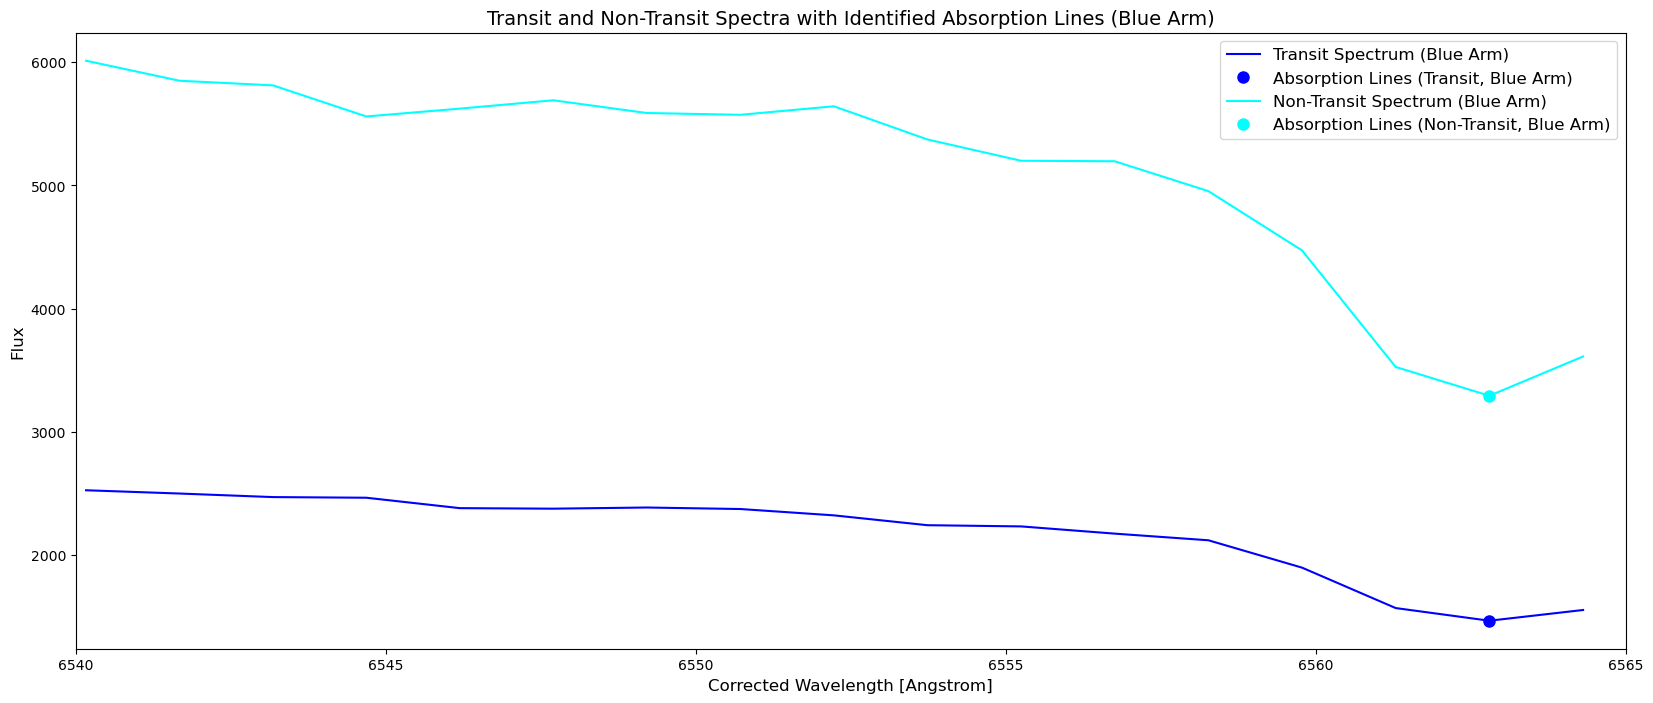

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema

def find_and_plot_absorption_lines(corrected_wavelength_transit_blue, corrected_wavelength_non_transit_blue, transit_spectrum_blue, non_transit_spectrum_blue, wavelength_range, sensitivity):
    # Select the data within the wavelength range
    mask_blue = (corrected_wavelength_transit_blue >= wavelength_range[0]) & (corrected_wavelength_transit_blue <= wavelength_range[1])

    # Check if there is any data in the wavelength range for the blue arm
    if not np.any(mask_blue):
        print("No data in the specified wavelength range for the blue arm.")
        return

    # Find local minima in the blue arm transit spectrum
    minima_transit_blue = argrelextrema(transit_spectrum_blue[mask_blue], np.less, order=10)[0]

    # Find local minima in the blue arm non-transit spectrum
    minima_non_transit_blue = argrelextrema(non_transit_spectrum_blue[mask_blue], np.less, order=10)[0]

    # Print the wavelength values corresponding to the identified absorption lines
    print("Absorption Lines in Transit Spectrum (Blue Arm):", corrected_wavelength_transit_blue[mask_blue][minima_transit_blue])
    print("Absorption Lines in Non-Transit Spectrum (Blue Arm):", corrected_wavelength_non_transit_blue[mask_blue][minima_non_transit_blue])

    # Create a new figure
    fig, ax = plt.subplots(figsize=(20, 8))

    # Plot the spectra with identified absorption lines
    if np.any(mask_blue):
        ax.plot(corrected_wavelength_transit_blue[mask_blue], transit_spectrum_blue[mask_blue], label='Transit Spectrum (Blue Arm)', color='blue')
        ax.plot(corrected_wavelength_transit_blue[mask_blue][minima_transit_blue], transit_spectrum_blue[mask_blue][minima_transit_blue], 'o', color='blue', markersize=8, label='Absorption Lines (Transit, Blue Arm)')

        ax.plot(corrected_wavelength_non_transit_blue[mask_blue], non_transit_spectrum_blue[mask_blue], label='Non-Transit Spectrum (Blue Arm)', color='cyan')
        ax.plot(corrected_wavelength_non_transit_blue[mask_blue][minima_non_transit_blue], non_transit_spectrum_blue[mask_blue][minima_non_transit_blue], 'o', color='cyan', markersize=8, label='Absorption Lines (Non-Transit, Blue Arm)')

    # Set x-axis limits
    ax.set_xlim(wavelength_range[0], wavelength_range[1])

    # Adjust the figure layout
    ax.set_xlabel('Corrected Wavelength [Angstrom]', fontsize=12)
    ax.set_ylabel('Flux', fontsize=12)
    ax.legend(fontsize=12)
    ax.set_title('Transit and Non-Transit Spectra with Identified Absorption Lines (Blue Arm)', fontsize=14)

    plt.show()

# Example usage (replace with your actual data)
find_and_plot_absorption_lines(corrected_wavelength_blue_transit, corrected_wavelength_blue_non_transit, transit_blue_common, non_transit_blue_common, [6540, 6565], sensitivity=0.01)



In [11]:
print(np.min(corrected_wavelength_blue_transit),np.max(corrected_wavelength_blue_transit)) #blue arm transit
print(np.min(corrected_wavelength_blue_non_transit),np.max(corrected_wavelength_blue_non_transit)) #blue arm non transit

3698.3098 9084.896
3698.3098 9084.896


Absorption Lines (Blue Arm): [4409.964  4426.2466 4433.3896 ... 9059.823  9070.262  9072.352 ]
Emission Lines (Blue Arm): [3698.3098 3699.1619 3700.0142 3700.8665 3701.7192 3702.572  3703.425
 3704.2783 3705.1316 3705.9854 3706.839  3707.693  3708.5474 3709.4016
 3710.2563 3711.111  3711.966  3712.8213 3713.6768 3714.5322 3715.3882
 3716.2441 3717.1003 3717.9565 3718.8132 3719.67   3720.5269 3721.384
 3722.2415 3723.099  3723.9568 3724.8147 3725.6729 3726.5312 3727.39
 3728.2485 3729.1074 3729.9668 3730.826  3731.6855 3732.5454 3735.1257
 3735.9863 3736.847  3737.7078 3738.569  3739.4304 3740.2917 3741.1536
 3742.0154 3742.8777 3743.74   3744.6025 3745.465  3746.3281 3747.1912
 3748.0544 3750.6455 3751.5098 3752.374  3753.2385 3754.1033 3754.968
 3755.8333 3756.6985 3757.564  3758.4297 3759.2957 3760.1616 3761.028
 3761.8945 3762.7612 3763.6282 3764.495  3765.3625 3766.23   3767.0977
 3767.9656 3768.8335 3769.702  3770.5703 3771.4392 3772.3079 3773.177
 3774.0464 3774.9158 3775.7856 37

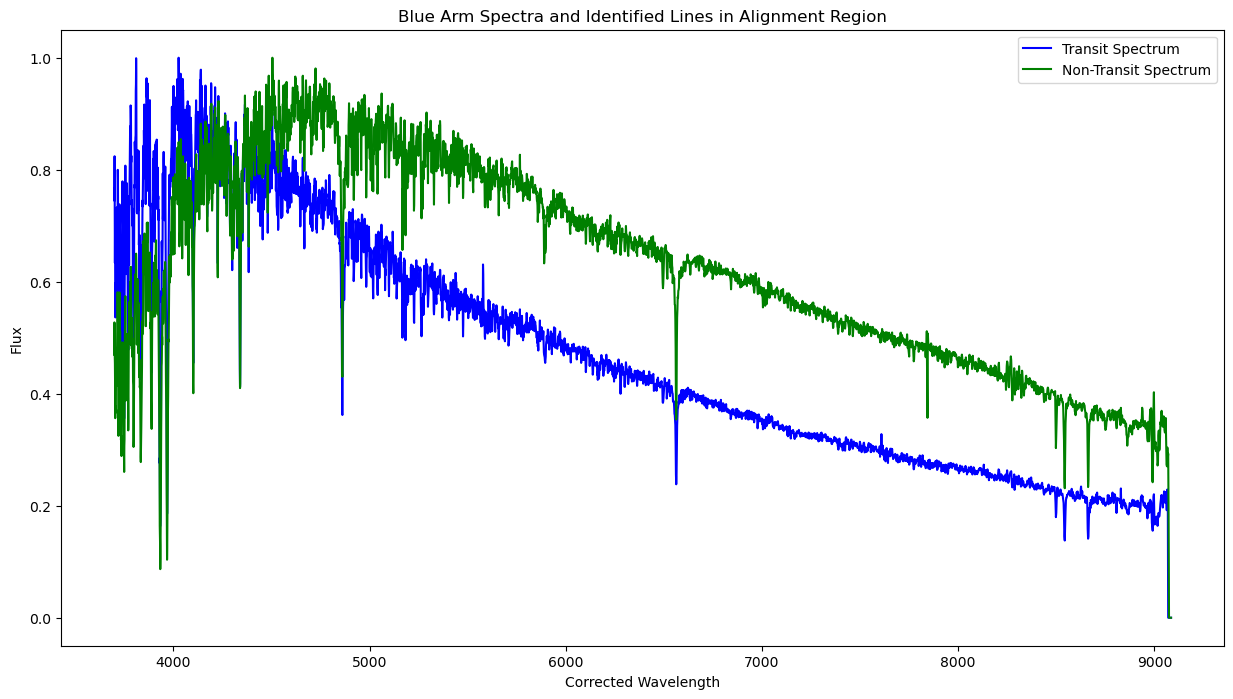

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Function to identify absorption and emission lines within user-specified alignment regions
def identify_lines_in_alignment_region(transit_wavelength, transit_flux, non_transit_wavelength, non_transit_flux,
                                       alignment_region, threshold=0.1):
    # Check if the alignment region is provided
    if alignment_region is None or len(alignment_region) != 2:
        print("Invalid alignment region.")
        return np.array([]), np.array([])

    # Extract the alignment region for both spectra
    transit_mask = np.logical_and(transit_wavelength >= alignment_region[0], transit_wavelength <= alignment_region[1])
    non_transit_mask = np.logical_and(non_transit_wavelength >= alignment_region[0], non_transit_wavelength <= alignment_region[1])

    transit_wavelength_aligned = transit_wavelength[transit_mask]
    non_transit_wavelength_aligned = non_transit_wavelength[non_transit_mask]

    transit_flux_aligned = transit_flux[transit_mask]
    non_transit_flux_aligned = non_transit_flux[non_transit_mask]

    # Ensure both spectra have the same length in the alignment region
    if len(transit_flux_aligned) != len(non_transit_flux_aligned):
        print("Spectra have different lengths in the alignment region. Unable to perform direct subtraction.")
        return np.array([]), np.array([])

    # Calculate residuals (difference) between transit and non-transit flux in the alignment region
    residuals = transit_flux_aligned - non_transit_flux_aligned

    # Identify absorption lines (where residuals are negative)
    absorption_lines = transit_wavelength_aligned[residuals < -threshold]

    # Identify emission lines (where residuals are positive)
    emission_lines = transit_wavelength_aligned[residuals > threshold]

    return absorption_lines, emission_lines


# Blue arm alignment region
alignment_region_blue = [3698.3098, 9084.896]  # Replace with your specified alignment region

# Identify absorption and emission lines for the blue arm using specified alignment region
absorption_lines_blue, emission_lines_blue = identify_lines_in_alignment_region(
    corrected_wavelength_blue_transit, normalized_blue,
    corrected_wavelength_blue_non_transit, normalized_non_transit_blue,
    alignment_region_blue
)

# Print or use the identified lines as needed
print("Absorption Lines (Blue Arm):", absorption_lines_blue)
print("Emission Lines (Blue Arm):", emission_lines_blue)

# Plot the spectra and identified lines for the blue arm using specified alignment region
plt.figure(figsize=(15, 8))
plt.plot(corrected_wavelength_blue_transit, normalized_blue, label='Transit Spectrum', color='blue')
plt.plot(corrected_wavelength_blue_non_transit, normalized_non_transit_blue, label='Non-Transit Spectrum', color='green')
#plt.scatter(absorption_lines_blue, np.ones_like(absorption_lines_blue), color='red', marker='v', label='Absorption Lines')
#plt.scatter(emission_lines_blue, np.ones_like(emission_lines_blue), color='purple', marker='^', label='Emission Lines')
plt.xlabel('Corrected Wavelength')
plt.ylabel('Flux')
plt.legend(loc='upper right')  # Adjust legend position
plt.title('Blue Arm Spectra and Identified Lines in Alignment Region')
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Function to identify absorption and emission lines within user-specified alignment regions
def identify_lines_in_common_range(transit_wavelength, transit_flux, non_transit_wavelength, non_transit_flux,
                                   common_range, min_snr=10, window_size=10):
    # Ensure common_range is not empty
    if len(common_range) == 0:
        print("No common wavelength range found.")
        return np.array([]), np.array([]), np.array([])

    # Interpolate flux values for one spectrum onto the wavelength grid of the other
    f_transit = interp1d(transit_wavelength, transit_flux, kind='linear', fill_value="extrapolate")
    f_non_transit = interp1d(non_transit_wavelength, non_transit_flux, kind='linear', fill_value="extrapolate")

    # Evaluate interpolated flux values at the common wavelength range
    flux_transit_interpolated = f_transit(common_range)
    flux_non_transit_interpolated = f_non_transit(common_range)

    # Calculate residuals (difference) between transit and non-transit flux in the common range
    residuals = flux_transit_interpolated - flux_non_transit_interpolated
    
    # Calculate adaptive threshold for each data point using rolling window
    threshold = adaptive_threshold_with_snr(residuals, window_size, min_snr)

    # Identify absorption lines (where residuals are below the negative threshold)
    absorption_lines = common_range[residuals < -threshold]

    # Identify emission lines (where residuals are above the positive threshold)
    emission_lines = common_range[residuals > threshold]

    return absorption_lines, emission_lines, residuals

'''
def adaptive_threshold(residuals, window_size, significance_factor=3):
    half_window = window_size // 2
    threshold = np.zeros_like(residuals)

    for i in range(len(residuals)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(residuals), i + half_window + 1)
        local_std = np.std(residuals[start_idx:end_idx])
        threshold[i] = significance_factor * local_std

    return threshold
'''

def adaptive_threshold_with_snr(residuals, window_size, min_snr=10):
    half_window = window_size // 2
    threshold = np.zeros_like(residuals)

    for i in range(len(residuals)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(residuals), i + half_window + 1)
        local_std = np.std(residuals[start_idx:end_idx])
        snr = np.abs(residuals[i]) / local_std if local_std != 0 else 0  # Prevent division by zero
        threshold[i] = min_snr * local_std if snr >= min_snr else 0  # Set threshold based on minimum SNR

    return threshold

# Blue arm alignment region
common_range_blue = np.linspace(3698.3098, 9084.896, 5000)  # Replace with your specified alignment region

# Identify absorption and emission lines for the blue arm using specified alignment region
absorption_lines_blue, emission_lines_blue, residuals_blue = identify_lines_in_common_range(
    corrected_wavelength_blue_transit, normalized_blue,
    corrected_wavelength_blue_non_transit, normalized_non_transit_blue,
    common_range_blue
)

# Print or use the identified lines and residuals as needed
print("Absorption Lines (Blue Arm):", absorption_lines_blue)
print("Emission Lines (Blue Arm):", emission_lines_blue)


Absorption Lines (Blue Arm): [4229.53344405 4230.6109768  4231.68850954 ... 9071.96560704 9073.04313979
 9074.12067253]
Emission Lines (Blue Arm): [3698.3098     3699.38733275 3700.46486549 3701.54239824 3702.61993099
 3703.69746373 3704.77499648 3705.85252923 3706.93006197 3708.00759472
 3709.08512747 3710.16266021 3711.24019296 3712.31772571 3713.39525845
 3714.4727912  3715.55032394 3716.62785669 3717.70538944 3718.78292218
 3719.86045493 3720.93798768 3722.01552042 3723.09305317 3724.17058592
 3725.24811866 3726.32565141 3727.40318416 3728.4807169  3729.55824965
 3730.6357824  3731.71331514 3732.79084789 3733.86838064 3734.94591338
 3736.02344613 3737.10097888 3738.17851162 3739.25604437 3740.33357712
 3741.41110986 3742.48864261 3743.56617536 3744.6437081  3745.72124085
 3746.79877359 3747.87630634 3748.95383909 3750.03137183 3751.10890458
 3752.18643733 3753.26397007 3754.34150282 3755.41903557 3756.49656831
 3757.57410106 3758.65163381 3759.72916655 3760.8066993  3761.88423205
 

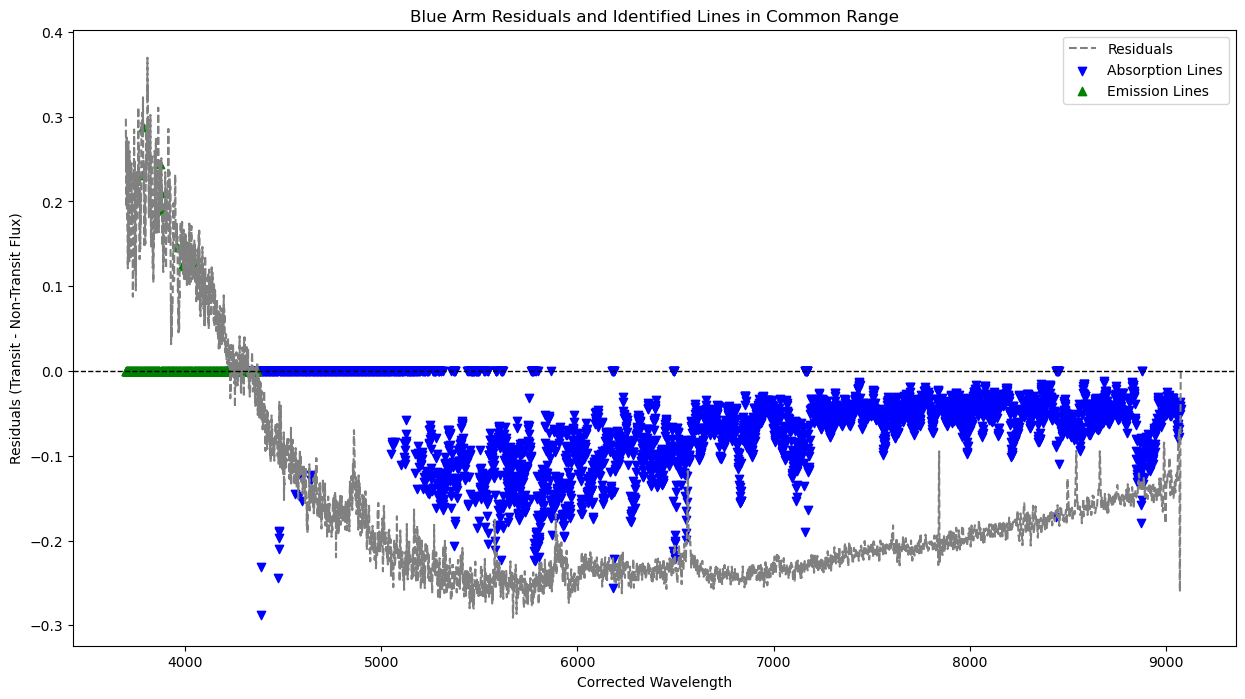

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Function to identify absorption and emission lines within user-specified alignment regions
def identify_lines_in_common_range(transit_wavelength, transit_flux, non_transit_wavelength, non_transit_flux,
                                   common_range, min_snr=10, window_size=10):
    # Ensure common_range is not empty
    if len(common_range) == 0:
        print("No common wavelength range found.")
        return np.array([]), np.array([]), np.array([]), np.array([])

    # Interpolate flux values for one spectrum onto the wavelength grid of the other
    f_transit = interp1d(transit_wavelength, transit_flux, kind='linear', fill_value="extrapolate")
    f_non_transit = interp1d(non_transit_wavelength, non_transit_flux, kind='linear', fill_value="extrapolate")

    # Evaluate interpolated flux values at the common wavelength range
    flux_transit_interpolated = f_transit(common_range)
    flux_non_transit_interpolated = f_non_transit(common_range)

    # Calculate residuals (difference) between transit and non-transit flux in the common range
    residuals = flux_transit_interpolated - flux_non_transit_interpolated
    
    # Calculate adaptive threshold for each data point using rolling window
    threshold = adaptive_threshold_with_snr(residuals, window_size, min_snr)

    # Identify absorption lines (where residuals are below the negative threshold)
    absorption_lines = common_range[residuals < -threshold]

    # Identify emission lines (where residuals are above the positive threshold)
    emission_lines = common_range[residuals > threshold]

    return absorption_lines, emission_lines, residuals, threshold
'''
def adaptive_threshold(residuals, window_size, significance_factor=3):
    half_window = window_size // 2
    threshold = np.zeros_like(residuals)

    for i in range(len(residuals)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(residuals), i + half_window + 1)
        local_std = np.std(residuals[start_idx:end_idx])
        threshold[i] = significance_factor * local_std

    return threshold
'''

def adaptive_threshold_with_snr(residuals, window_size, min_snr=10):
    half_window = window_size // 2
    threshold = np.zeros_like(residuals)

    for i in range(len(residuals)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(residuals), i + half_window + 1)
        local_std = np.std(residuals[start_idx:end_idx])
        snr = np.abs(residuals[i]) / local_std if local_std != 0 else 0  # Prevent division by zero
        threshold[i] = min_snr * local_std if snr >= min_snr else 0  # Set threshold based on minimum SNR

    return threshold

# Blue arm alignment region
common_range_blue = np.linspace(3698.3098, 9084.896, 5000)  # Replace with your specified alignment region

# Identify absorption and emission lines for the blue arm using specified alignment region
absorption_lines_blue, emission_lines_blue, residuals_blue, threshold_blue = identify_lines_in_common_range(
    corrected_wavelength_blue_transit, normalized_blue,
    corrected_wavelength_blue_non_transit, normalized_non_transit_blue,
    common_range_blue
)

# Plot the residuals and identified lines
plt.figure(figsize=(15, 8))
plt.plot(common_range_blue, residuals_blue, label='Residuals', color='gray', linestyle='dashed')

# Plot absorption lines
for wavelength, threshold_value in zip(absorption_lines_blue, -threshold_blue):
    plt.scatter(wavelength, threshold_value, color='blue', marker='v', label='Absorption Lines' if wavelength == absorption_lines_blue[0] else None)

# Plot emission lines
for wavelength, threshold_value in zip(emission_lines_blue, threshold_blue):
    plt.scatter(wavelength, threshold_value, color='green', marker='^', label='Emission Lines' if wavelength == emission_lines_blue[0] else None)

plt.axhline(0, color='black', linestyle='dashed', linewidth=1)
plt.xlabel('Corrected Wavelength')
plt.ylabel('Residuals (Transit - Non-Transit Flux)')
plt.legend(loc='upper right')  # Adjust legend position
plt.title('Blue Arm Residuals and Identified Lines in Common Range')
plt.show()


In [15]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

def load_csv(file_path):
    df = pd.read_csv(file_path)
    # Drop rows with NaN values in the 'obs_wl_air(A)' column
    df.dropna(subset=['obs_wl_air(A)'], inplace=True)
    return df

def identify_lines_in_common_range(transit_wavelength, transit_flux, non_transit_wavelength, non_transit_flux,
                                   common_range, min_snr=10, window_size=10):
    # Ensure common_range is not empty
    if len(common_range) == 0:
        print("No common wavelength range found.")
        return np.array([]), np.array([]), np.array([])

    # Interpolate flux values for one spectrum onto the wavelength grid of the other
    f_transit = interp1d(transit_wavelength, transit_flux, kind='linear', fill_value="extrapolate")
    f_non_transit = interp1d(non_transit_wavelength, non_transit_flux, kind='linear', fill_value="extrapolate")

    # Evaluate interpolated flux values at the common wavelength range
    flux_transit_interpolated = f_transit(common_range)
    flux_non_transit_interpolated = f_non_transit(common_range)

    # Calculate residuals (difference) between transit and non-transit flux in the common range
    residuals = flux_transit_interpolated - flux_non_transit_interpolated
    
    # Calculate adaptive threshold for each data point using rolling window
    threshold = adaptive_threshold_with_snr(residuals, window_size, min_snr)

    # Identify absorption lines (where residuals are below the negative threshold)
    absorption_lines = common_range[residuals < -threshold]

    # Identify emission lines (where residuals are above the positive threshold)
    emission_lines = common_range[residuals > threshold]

    return absorption_lines, emission_lines, residuals

'''
def adaptive_threshold(residuals, window_size, significance_factor=3):
    half_window = window_size // 2
    threshold = np.zeros_like(residuals)

    for i in range(len(residuals)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(residuals), i + half_window + 1)
        local_std = np.std(residuals[start_idx:end_idx])
        threshold[i] = significance_factor * local_std

    return threshold
'''

def adaptive_threshold_with_snr(residuals, window_size, min_snr=10):
    half_window = window_size // 2
    threshold = np.zeros_like(residuals)

    for i in range(len(residuals)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(residuals), i + half_window + 1)
        local_std = np.std(residuals[start_idx:end_idx])
        snr = np.abs(residuals[i]) / local_std if local_std != 0 else 0  # Prevent division by zero
        threshold[i] = min_snr * local_std if snr >= min_snr else 0  # Set threshold based on minimum SNR

    return threshold

# Function to cross-check wavelengths with CSV data
def cross_check_wavelengths_with_csv(wavelengths, df, tolerance=0.1):
    ions = []
    sp_nums = []

    # Iterate over each wavelength
    for wavelength in wavelengths:
        # Find the closest wavelength in the CSV data within the specified tolerance
        closest_matches = df[df['obs_wl_air(A)'].between(wavelength - tolerance, wavelength + tolerance)]

        # Extract corresponding ion and sp_num from the CSV data
        if not closest_matches.empty:
            ion = closest_matches['element'].values[0]
            sp_num = closest_matches['sp_num'].values[0]

            # Append results to lists
            ions.append(ion)
            sp_nums.append(sp_num)
        else:
            # Append placeholders if no match is found
            ions.append(None)
            sp_nums.append(None)

    return ions, sp_nums

# Function to print cross-checked results
def print_results(lines, ions, sp_nums, arm_name):
    print(f"Cross-checked {len(lines)} Lines ({arm_name} Arm):")
    
    min_length = min(len(lines), len(ions), len(sp_nums))
    
    for i in range(min_length):
        print(f"Wavelength: {lines[i]}, Ion: {ions[i]}, sp_num: {sp_nums[i]}")

# Load CSV data
df = load_csv('lines.csv')

# Blue arm alignment region
common_range_blue = np.linspace(3698.3098, 9084.896, 5000)
absorption_lines_blue, emission_lines_blue, residuals_blue = identify_lines_in_common_range(
    corrected_wavelength_blue_transit, normalized_blue,
    corrected_wavelength_blue_non_transit, normalized_non_transit_blue,
    common_range_blue
)

# Cross-check absorption and emission lines for the Blue Arm
ions_blue, sp_nums_blue = cross_check_wavelengths_with_csv(absorption_lines_blue, df)
print_results(absorption_lines_blue, ions_blue, sp_nums_blue, "Blue Absorption")
print_results(emission_lines_blue, ions_blue, sp_nums_blue, "Blue Emission")  # Corrected line



Cross-checked 4430 Lines (Blue Absorption Arm):
Wavelength: 4229.5334440488095, Ion: None, sp_num: None
Wavelength: 4230.610976795359, Ion: None, sp_num: None
Wavelength: 4231.688509541908, Ion: None, sp_num: None
Wavelength: 4232.766042288458, Ion: None, sp_num: None
Wavelength: 4233.843575035007, Ion: None, sp_num: None
Wavelength: 4237.076173274655, Ion: None, sp_num: None
Wavelength: 4238.153706021204, Ion: None, sp_num: None
Wavelength: 4241.386304260852, Ion: None, sp_num: None
Wavelength: 4242.463837007402, Ion: None, sp_num: None
Wavelength: 4243.541369753951, Ion: None, sp_num: None
Wavelength: 4245.6964352470495, Ion: None, sp_num: None
Wavelength: 4251.084098979796, Ion: None, sp_num: None
Wavelength: 4252.161631726345, Ion: None, sp_num: None
Wavelength: 4253.239164472895, Ion: None, sp_num: None
Wavelength: 4254.316697219444, Ion: None, sp_num: None
Wavelength: 4256.471762712543, Ion: None, sp_num: None
Wavelength: 4258.626828205641, Ion: None, sp_num: None
Wavelength: 425

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def identify_significant_lines(ratio_values, threshold_values, significance_factor):
    significant_absorption_lines = []
    significant_emission_lines = []
    for i in range(len(ratio_values)):
        if ratio_values[i] < 1 and ratio_values[i] < significance_factor * threshold_values[i]:
            significant_absorption_lines.append(i)
        elif ratio_values[i] > 1 and ratio_values[i] > significance_factor * threshold_values[i]:
            significant_emission_lines.append(i)
    return significant_absorption_lines, significant_emission_lines

def identify_lines_in_common_range(transit_wavelength, transit_flux, non_transit_wavelength, non_transit_flux,
                                   common_range, significance_factor=10, window_size=10):
    # Ensure common_range is not empty
    if len(common_range) == 0:
        print("No common wavelength range found.")
        return np.array([]), np.array([]), np.array([])

    # Interpolate flux values for one spectrum onto the wavelength grid of the other
    f_transit = interp1d(transit_wavelength, transit_flux, kind='linear', fill_value="extrapolate")
    f_non_transit = interp1d(non_transit_wavelength, non_transit_flux, kind='linear', fill_value="extrapolate")

    # Evaluate interpolated flux values at the common wavelength range
    flux_transit_interpolated = f_transit(common_range)
    flux_non_transit_interpolated = f_non_transit(common_range)

    # Calculate the ratio of transit to non-transit flux
    ratio = np.zeros_like(flux_transit_interpolated)  # Initialize ratio array

    # Avoid division by zero
    non_zero_indices = flux_non_transit_interpolated != 0
    ratio[non_zero_indices] = flux_transit_interpolated[non_zero_indices] / flux_non_transit_interpolated[non_zero_indices]

    # Calculate adaptive threshold for each data point using rolling window
    threshold = adaptive_threshold(ratio, window_size, significance_factor)

    # Identify significant absorption and emission lines
    significant_absorption_lines, significant_emission_lines = identify_significant_lines(ratio, threshold, significance_factor)

    return significant_absorption_lines, significant_emission_lines, ratio


'''
def adaptive_threshold(ratio_values, window_size, significance_factor=3):
    half_window = window_size // 2
    threshold = np.zeros_like(ratio_values)

    for i in range(len(ratio_values)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(ratio_values), i + half_window + 1)
        local_std = np.std(ratio_values[start_idx:end_idx])
        threshold[i] = max(0, min(1, significance_factor * local_std))

    return threshold
'''
def adaptive_threshold(ratio_values, window_size, significance_factor=10):
    half_window = window_size // 2
    threshold = np.zeros_like(ratio_values)

    for i in range(len(ratio_values)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(ratio_values), i + half_window + 1)
        local_std = np.std(ratio_values[start_idx:end_idx])
        snr = np.abs(ratio_values[i]) / local_std if local_std != 0 else 0  # Calculate SNR
        threshold[i] = significance_factor * snr

    return threshold

# Blue arm alignment region
common_range_blue = np.linspace(3698.3098, 9084.896, 5000)  # Replace with your specified alignment region

# Identify absorption and emission lines for the blue arm using specified alignment region
absorption_lines_blue, emission_lines_blue, ratio_blue = identify_lines_in_common_range(
    corrected_wavelength_blue_transit, normalized_blue,
    corrected_wavelength_blue_non_transit, normalized_non_transit_blue,
    common_range_blue
)

# Print the identified lines for the blue arm
print("Absorption Lines (Blue Arm):", common_range_blue[absorption_lines_blue])
print("Emission Lines (Blue Arm):", common_range_blue[emission_lines_blue])


Absorption Lines (Blue Arm): [4229.53344405 4230.6109768  4231.68850954 ... 9067.65547606 9068.7330088
 9069.81054155]
Emission Lines (Blue Arm): []


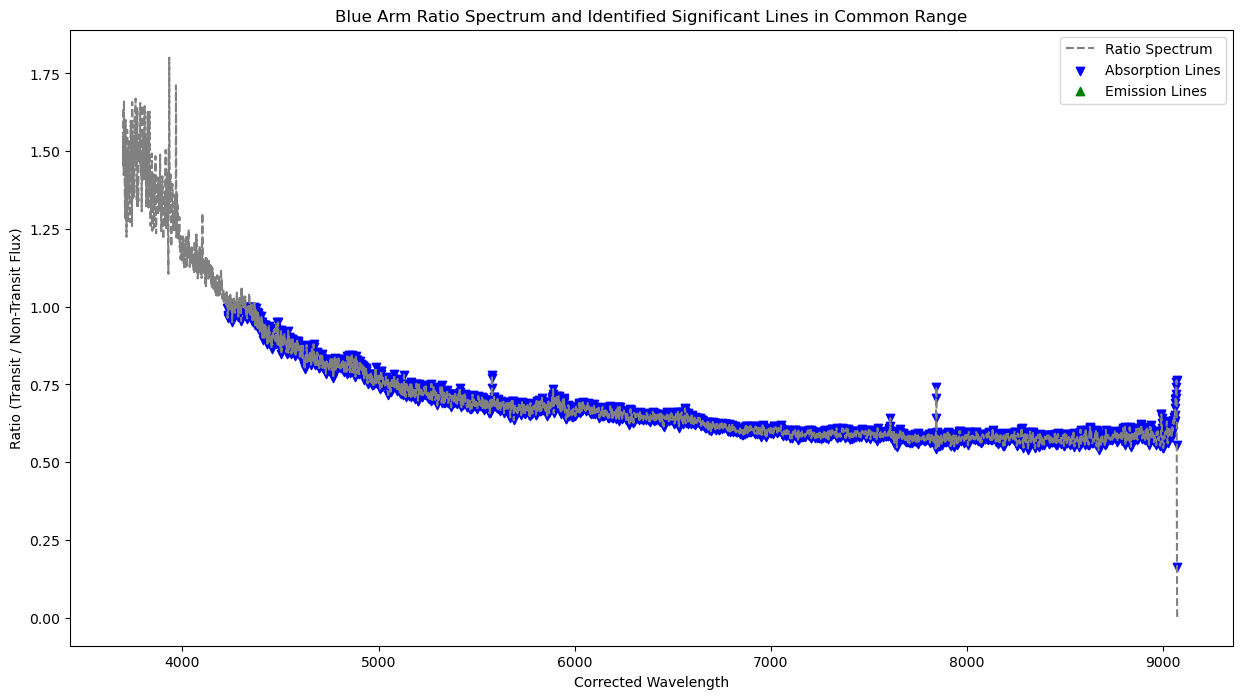

In [17]:
def identify_significant_lines(ratio_values, threshold_values, significance_factor):
    significant_absorption_lines = []
    significant_emission_lines = []
    for i in range(len(ratio_values)):
        if ratio_values[i] < 1 and ratio_values[i] < significance_factor * threshold_values[i]:
            significant_absorption_lines.append(i)
        elif ratio_values[i] > 1 and ratio_values[i] > significance_factor * threshold_values[i]:
            significant_emission_lines.append(i)
    return significant_absorption_lines, significant_emission_lines

def plot_significant_lines(wavelengths, values, significant_lines, color, marker, label):
    plt.scatter(wavelengths[significant_lines], values[significant_lines], color=color, marker=marker, label=label)

def identify_lines_in_common_range(transit_wavelength, transit_flux, non_transit_wavelength, non_transit_flux,
                                   common_range, significance_factor=10, window_size=10):
    # Ensure common_range is not empty
    if len(common_range) == 0:
        print("No common wavelength range found.")
        return np.array([]), np.array([]), np.array([])

    # Interpolate flux values for one spectrum onto the wavelength grid of the other
    f_transit = interp1d(transit_wavelength, transit_flux, kind='linear', fill_value="extrapolate")
    f_non_transit = interp1d(non_transit_wavelength, non_transit_flux, kind='linear', fill_value="extrapolate")

    # Evaluate interpolated flux values at the common wavelength range
    flux_transit_interpolated = f_transit(common_range)
    flux_non_transit_interpolated = f_non_transit(common_range)

    # Calculate the ratio of transit to non-transit flux
    ratio = np.zeros_like(flux_transit_interpolated)  # Initialize ratio array

    # Avoid division by zero
    non_zero_indices = flux_non_transit_interpolated != 0
    ratio[non_zero_indices] = flux_transit_interpolated[non_zero_indices] / flux_non_transit_interpolated[non_zero_indices]

    # Calculate adaptive threshold for each data point using rolling window
    threshold = adaptive_threshold(ratio, window_size, significance_factor)

    # Identify significant absorption and emission lines
    significant_absorption_lines, significant_emission_lines = identify_significant_lines(ratio, threshold, significance_factor)

    return significant_absorption_lines, significant_emission_lines, ratio, threshold
'''
def adaptive_threshold(ratio_values, window_size, significance_factor=3):
    half_window = window_size // 2
    threshold = np.zeros_like(ratio_values)

    for i in range(len(ratio_values)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(ratio_values), i + half_window + 1)
        local_std = np.std(ratio_values[start_idx:end_idx])
        threshold[i] = max(0, min(1, significance_factor * local_std))

    return threshold
'''
def adaptive_threshold(ratio_values, window_size, significance_factor=10):
    half_window = window_size // 2
    threshold = np.zeros_like(ratio_values)

    for i in range(len(ratio_values)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(ratio_values), i + half_window + 1)
        local_std = np.std(ratio_values[start_idx:end_idx])
        snr = np.abs(ratio_values[i]) / local_std if local_std != 0 else 0  # Calculate SNR
        threshold[i] = significance_factor * snr

    return threshold

# Blue arm alignment region
common_range_blue = np.linspace(3698.3098, 9084.896, 5000)  # Replace with your specified alignment region

# Identify significant absorption and emission lines for the blue arm using specified alignment region
significant_absorption_lines_blue, significant_emission_lines_blue, ratio_blue, threshold_blue = identify_lines_in_common_range(
    corrected_wavelength_blue_transit, normalized_blue,
    corrected_wavelength_blue_non_transit, normalized_non_transit_blue,
    common_range_blue
)

# Plot the ratio spectrum and identified significant lines
plt.figure(figsize=(15, 8))
plt.plot(common_range_blue, ratio_blue, label='Ratio Spectrum', color='gray', linestyle='dashed')

# Plot significant absorption lines
plot_significant_lines(common_range_blue, ratio_blue, significant_absorption_lines_blue, 'blue', 'v', 'Absorption Lines')

# Plot significant emission lines
plot_significant_lines(common_range_blue, ratio_blue, significant_emission_lines_blue, 'green', '^', 'Emission Lines')

# Plot the adaptive threshold
#plt.plot(common_range_blue, threshold_blue, label='Threshold', color='red', linestyle='dotted')

plt.xlabel('Corrected Wavelength')
plt.ylabel('Ratio (Transit / Non-Transit Flux)')
plt.legend(loc='upper right')  # Adjust legend position
plt.title('Blue Arm Ratio Spectrum and Identified Significant Lines in Common Range')
plt.show()


In [18]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

def load_csv(file_path):
    df = pd.read_csv(file_path)
    # Drop rows with NaN values in the 'obs_wl_air(A)' column
    df.dropna(subset=['obs_wl_air(A)'], inplace=True)
    return df

def identify_significant_lines(ratio_values, threshold_values, significance_factor=10):
    significant_absorption_lines = []
    significant_emission_lines = []
    for i in range(len(ratio_values)):
        if ratio_values[i] < 1 and ratio_values[i] < significance_factor * threshold_values[i]:
            significant_absorption_lines.append(i)
        elif ratio_values[i] > 1 and ratio_values[i] > significance_factor * threshold_values[i]:
            significant_emission_lines.append(i)
    return significant_absorption_lines, significant_emission_lines

def identify_lines_in_common_range(transit_wavelength, transit_flux, non_transit_wavelength, non_transit_flux,
                                   common_range, significance_factor=10, window_size=10):
    # Ensure common_range is not empty
    if len(common_range) == 0:
        print("No common wavelength range found.")
        return np.array([]), np.array([]), np.array([])

    # Interpolate flux values for one spectrum onto the wavelength grid of the other
    f_transit = interp1d(transit_wavelength, transit_flux, kind='linear', fill_value="extrapolate")
    f_non_transit = interp1d(non_transit_wavelength, non_transit_flux, kind='linear', fill_value="extrapolate")

    # Evaluate interpolated flux values at the common wavelength range
    flux_transit_interpolated = f_transit(common_range)
    flux_non_transit_interpolated = f_non_transit(common_range)

    # Calculate the ratio of transit to non-transit flux
    ratio = np.zeros_like(flux_transit_interpolated)  # Initialize ratio array

    # Avoid division by zero
    non_zero_indices = flux_non_transit_interpolated != 0
    ratio[non_zero_indices] = flux_transit_interpolated[non_zero_indices] / flux_non_transit_interpolated[non_zero_indices]

    # Calculate adaptive threshold for each data point using rolling window
    threshold = adaptive_threshold(ratio, window_size, significance_factor)

    # Identify significant absorption and emission lines
    significant_absorption_lines, significant_emission_lines = identify_significant_lines(ratio, threshold, significance_factor)

    return significant_absorption_lines, significant_emission_lines, ratio, threshold
'''
def adaptive_threshold(ratio_values, window_size, significance_factor=3):
    half_window = window_size // 2
    threshold = np.zeros_like(ratio_values)

    for i in range(len(ratio_values)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(ratio_values), i + half_window + 1)
        local_std = np.std(ratio_values[start_idx:end_idx])
        threshold[i] = max(0, min(1, significance_factor * local_std))

    return threshold
'''

def adaptive_threshold(ratio_values, window_size, significance_factor=10):
    half_window = window_size // 2
    threshold = np.zeros_like(ratio_values)

    for i in range(len(ratio_values)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(ratio_values), i + half_window + 1)
        local_std = np.std(ratio_values[start_idx:end_idx])
        snr = np.abs(ratio_values[i]) / local_std if local_std != 0 else 0  # Calculate SNR
        threshold[i] = significance_factor * snr

    return threshold

#cross check function
def cross_check_wavelengths_with_csv(wavelengths, df, tolerance=0.1):
    # Initialize lists to store results
    ions = []
    sp_nums = []

    # Iterate over each wavelength
    for wavelength in wavelengths:
        # Find the closest wavelength in the CSV data within the specified tolerance
        closest_matches = df[df['obs_wl_air(A)'].between(wavelength - tolerance, wavelength + tolerance)]

        # Extract corresponding ion and sp_num from the CSV data
        if not closest_matches.empty:
            ion = closest_matches['element'].values[0]
            sp_num = closest_matches['sp_num'].values[0]

            # Append results to lists
            ions.append(ion)
            sp_nums.append(sp_num)
        else:
            # Append placeholders if no match is found
            ions.append(None)
            sp_nums.append(None)

    return ions, sp_nums


def print_results(wavelengths, ions, sp_nums, arm_name):
    print(f"Cross-checked {len(wavelengths)} Lines ({arm_name} Arm):")
    
    min_length = min(len(wavelengths), len(ions), len(sp_nums))
    
    for i in range(min_length):
        print(f"Wavelength: {wavelengths[i]}, Ion: {ions[i]}, sp_num: {sp_nums[i]}")

# Load your CSV data
df = load_csv('lines.csv')

# Blue arm alignment region
common_range_blue = np.linspace(3698.3098, 9084.896, 5000)
absorption_lines_blue, emission_lines_blue, ratio_blue, threshold_blue = identify_lines_in_common_range(
    corrected_wavelength_blue_transit, normalized_blue,
    corrected_wavelength_blue_non_transit, normalized_non_transit_blue,
    common_range_blue
)

# Cross-check absorption and emission lines for the Blue Arm
ions_blue, sp_nums_blue = cross_check_wavelengths_with_csv([common_range_blue[i] for i in absorption_lines_blue], df)
print_results([common_range_blue[i] for i in absorption_lines_blue], ions_blue, sp_nums_blue, "Blue Absorption")
ions_blue, sp_nums_blue = cross_check_wavelengths_with_csv([common_range_blue[i] for i in emission_lines_blue], df)
print_results([common_range_blue[i] for i in emission_lines_blue], ions_blue, sp_nums_blue, "Blue Emission")  # Corrected line


Cross-checked 4426 Lines (Blue Absorption Arm):
Wavelength: 4229.5334440488095, Ion: None, sp_num: None
Wavelength: 4230.610976795359, Ion: None, sp_num: None
Wavelength: 4231.688509541908, Ion: None, sp_num: None
Wavelength: 4232.766042288458, Ion: None, sp_num: None
Wavelength: 4233.843575035007, Ion: None, sp_num: None
Wavelength: 4237.076173274655, Ion: None, sp_num: None
Wavelength: 4238.153706021204, Ion: None, sp_num: None
Wavelength: 4241.386304260852, Ion: None, sp_num: None
Wavelength: 4242.463837007402, Ion: None, sp_num: None
Wavelength: 4243.541369753951, Ion: None, sp_num: None
Wavelength: 4245.6964352470495, Ion: None, sp_num: None
Wavelength: 4251.084098979796, Ion: None, sp_num: None
Wavelength: 4252.161631726345, Ion: None, sp_num: None
Wavelength: 4253.239164472895, Ion: None, sp_num: None
Wavelength: 4254.316697219444, Ion: None, sp_num: None
Wavelength: 4256.471762712543, Ion: None, sp_num: None
Wavelength: 4258.626828205641, Ion: None, sp_num: None
Wavelength: 425